# Time Series Workflow

---

## 0) Imports

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
# from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

# from cleanup import clean_data
# from engineer import feature_engineer
# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

## 1) Define the Business Goal

Build a model that can predict tomorrows temperature, given the temprature until today, as precisely as possible.

## 2) Get the Data

### 2.1) Load the Data

In [519]:
df = pd.read_csv('TG_STAID002759.csv', index_col=1, parse_dates=True)
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


### 2.2) Clean the Data

In [520]:
def clean_data(df):
    df['TG'].replace(-9999, np.NaN, inplace=True)
    df['TG2']=df['TG']/10
    df = df.drop(['SOUID', 'TG','Q_TG'], axis=1)
    df = df.dropna()
    return df

In [521]:
df = clean_data(df)
df.head()

,TG2
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


## 3) Train-Test-Split

In [522]:
df_train = df[:-365]

df_test = df[-365:]

## 4) Visualize the Data

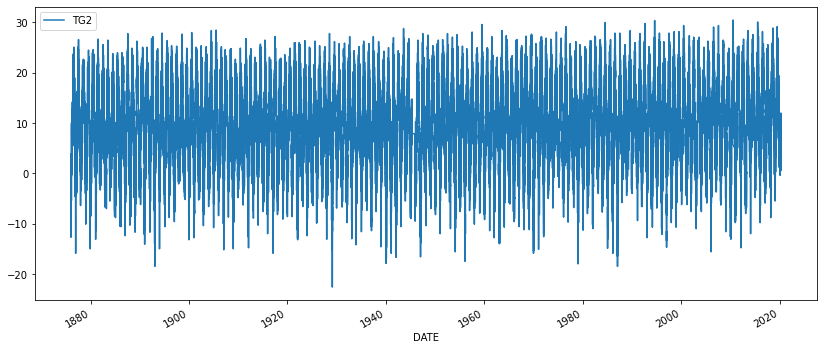

In [523]:
df_train.plot()

## 5) Feature Engineer

In [524]:
df_train.head()
#iterator = iter(range(len(df_train)))

,TG2
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [525]:
def plot_temp(df, title='Monthly mean temperature over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; default is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

In [526]:
# year trend 
df_train['timestep'] = range(len(df_train))

X = df_train[['timestep']] #matrix (or DataFrame)
y = df_train['TG2'] #vector (or Series)
m = LinearRegression()
m.fit(X, y)
m.coef_

<ipython-input-526-137cc0d45e3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['timestep'] = range(len(df_train))


array([3.15365807e-05])

In [527]:
#df_train['year_trend'] = m.predict(X)
#df_train[['TG2', 'year_trend']].plot()

In [528]:
def feature_engineer(df_train):
    #Extract the Timestep and the Seasonal Dummies
    df_train['timestep'] = range(len(df_train))
    
    seasonal_dummies = pd.get_dummies(df_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(df_train.index)

    df_train_fe = df_train.join(seasonal_dummies)
    
    # define remainder   
    m = LinearRegression()
    y_train = df_train_fe.copy().iloc[:,0]
    X_train = df_train_fe.copy().iloc[:,1:]
    m.fit(X_train, y_train)
    df_train_fe['trend_seasonal'] = m.predict(X_train)
    df_train_fe['remainder'] = df_train_fe['TG2'] - df_train_fe['trend_seasonal']
    
    # add lag（4）
    df_train_fe['lag1'] = df_train_fe['remainder'].shift(1)
    df_train_fe['lag2'] = df_train_fe['remainder'].shift(2)
    df_train_fe['lag3'] = df_train_fe['remainder'].shift(3)
    df_train_fe['lag4'] = df_train_fe['remainder'].shift(4)
    df_train_fe.dropna(inplace=True)
    
    # For assign X
    df_train_fe = df_train_fe.drop(columns=['trend_seasonal', 'remainder'])
    
    return df_train_fe

In [529]:
df_train_fe = feature_engineer(df_train)
df_train_fe.head()

<ipython-input-528-8f40635a29d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['timestep'] = range(len(df_train))


,TG2,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-4.938295,1.161738,3.361770,3.061802
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-8.938327,-4.938295,1.161738,3.361770
1876-01-07,-6.6,6,0,0,0,0,0,0,0,0,0,0,0,-6.838359,-8.938327,-4.938295,1.161738
1876-01-08,-8.9,7,0,0,0,0,0,0,0,0,0,0,0,-5.738391,-6.838359,-8.938327,-4.938295
1876-01-09,-12.7,8,0,0,0,0,0,0,0,0,0,0,0,-8.038424,-5.738391,-6.838359,-8.938327


In [530]:
# Now assign X and y
y_train = df_train_fe.copy().iloc[:,0]

X_train = df_train_fe.copy().iloc[:,1:]

In [531]:
X_train

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.938295,1.161738,3.361770,3.061802
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.938327,-4.938295,1.161738,3.361770
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0,-6.838359,-8.938327,-4.938295,1.161738
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0,-5.738391,-6.838359,-8.938327,-4.938295
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0,-8.038424,-5.738391,-6.838359,-8.938327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,52486,0,1,0,0,0,0,0,0,0,0,0,0.582748,-1.217220,-2.317187,-3.717155
2020-03-28,52487,0,1,0,0,0,0,0,0,0,0,0,4.182716,0.582748,-1.217220,-2.317187
2020-03-29,52488,0,1,0,0,0,0,0,0,0,0,0,2.882683,4.182716,0.582748,-1.217220


## 6) Train a model

In [532]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression()

**You will see other models this week!**

## 7) Cross-Validate and Optimize Hyperparameters

In [533]:
df_train_fe['pred'] = m.predict(X_train)
df_train_fe.head()

,TG2,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,pred
DATE,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-4.938295,1.161738,3.361770,3.061802,-5.354206
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-8.938327,-4.938295,1.161738,3.361770,-7.969080
1876-01-07,-6.6,6,0,0,0,0,0,0,0,0,0,0,0,-6.838359,-8.938327,-4.938295,1.161738,-5.643949
1876-01-08,-8.9,7,0,0,0,0,0,0,0,0,0,0,0,-5.738391,-6.838359,-8.938327,-4.938295,-5.359025
1876-01-09,-12.7,8,0,0,0,0,0,0,0,0,0,0,0,-8.038424,-5.738391,-6.838359,-8.938327,-7.631515


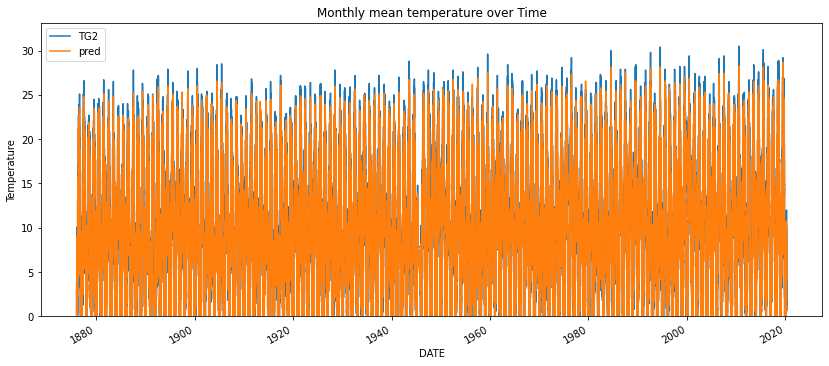

In [534]:
plot_temp(df_train_fe[['TG2', 'pred']])

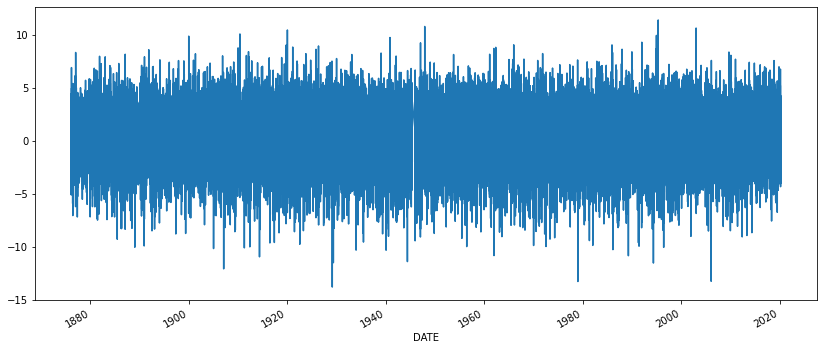

In [535]:
# analysis remainder 2nd round
df_train_fe['remainder'] = df_train_fe['TG2'] - df_train_fe['pred']
df_train_fe['remainder'].plot()

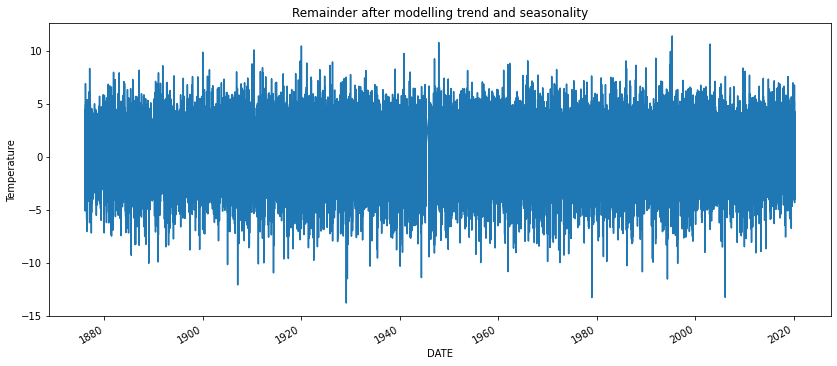

In [536]:
# another way of ploting
plot_temp(df_train_fe['remainder'], title='Remainder after modelling trend and seasonality', ylim=False)

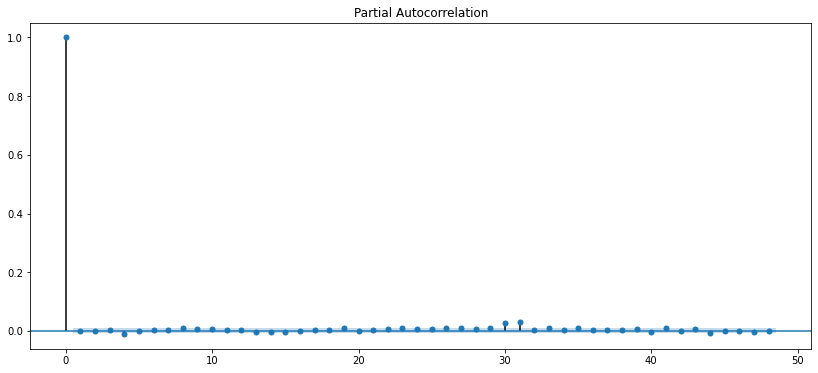

In [537]:
#Inspect the remainder to decide how many lags to include
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train_fe['remainder']);

In [538]:
# Let ar_select_order select the number of lags for the remainder
selected_order = ar_select_order(endog=df_train_fe['remainder'], maxlag=12)

/home/guo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/guo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [539]:
# Inspect the number of lags chosen
selected_order.ar_lags

array([], dtype=int64)

In [540]:
# statsmodels also has an AutoReg which does a bit of the modelling for you
#from statsmodels.tsa.ar_model import AutoReg
#ar_model = AutoReg(endog=df_train_fe['remainder'], lags=4).fit()
# Look at the model summary
#ar_model.summary()

In [541]:
X_full = df_train_fe.drop(columns=['TG2', 'pred', 'remainder'])
y_full = df_train_fe['TG2']

In [542]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.938295,1.161738,3.361770,3.061802
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.938327,-4.938295,1.161738,3.361770
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0,-6.838359,-8.938327,-4.938295,1.161738
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0,-5.738391,-6.838359,-8.938327,-4.938295
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0,-8.038424,-5.738391,-6.838359,-8.938327


In [543]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [544]:
# Create a new predictions column
df_train_fe['predictions_full_model'] = m_full.predict(X_full)

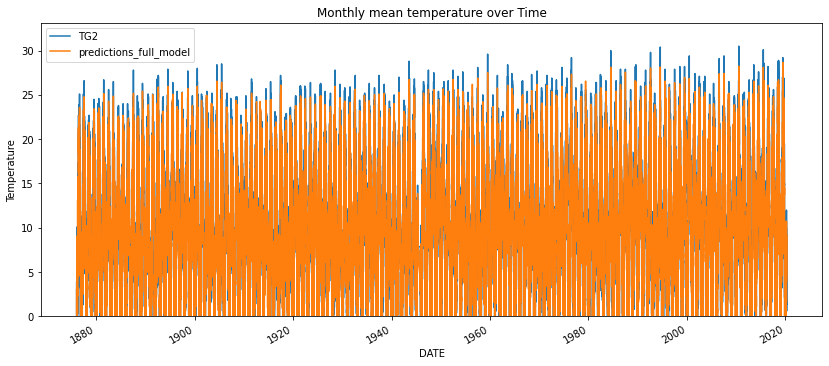

In [545]:
plot_temp(df_train_fe[['TG2',  'predictions_full_model']])

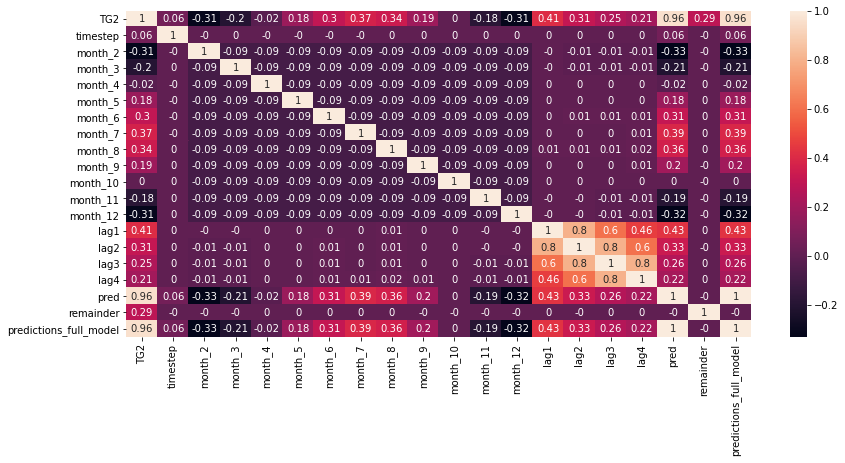

In [546]:
# Inspect correlations
correlations = round(df_train_fe.corr(), 2)
sns.heatmap(correlations, annot=True)

In [547]:
# cross validation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)
ts_split.split(X_full, y_full)
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index}')
    print()

The training data for the 1th iteration are the observations [   0    1    2 ... 8749 8750 8751]
The validation data for the 1th iteration are the observations [ 8752  8753  8754 ... 17496 17497 17498]

The training data for the 2th iteration are the observations [    0     1     2 ... 17496 17497 17498]
The validation data for the 2th iteration are the observations [17499 17500 17501 ... 26243 26244 26245]

The training data for the 3th iteration are the observations [    0     1     2 ... 26243 26244 26245]
The validation data for the 3th iteration are the observations [26246 26247 26248 ... 34990 34991 34992]

The training data for the 4th iteration are the observations [    0     1     2 ... 34990 34991 34992]
The validation data for the 4th iteration are the observations [34993 34994 34995 ... 43737 43738 43739]

The training data for the 5th iteration are the observations [    0     1     2 ... 43737 43738 43739]
The validation data for the 5th iteration are the observations [437

In [548]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [549]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
result

array([0.90452439, 0.91238667, 0.91399293, 0.90880465, 0.91787998])

In [550]:
result.mean()

0.911517725745259

In [551]:
import numpy as np
from matplotlib import pyplot as plt
import statsmodels

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
import seaborn as sns

def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)

In [552]:
print_adf(df_train_fe['remainder'])

adf_stats: -33.7013113767831
            p: 0.0 
            used lag: 34 
            number of observations: 52452
            CI 99%: -3.4304746781830016
            CI 95%: -2.8615951052531075
            CI 90%: -2.5667993306938484
            information criterion (AIC): 236568.0230080661
            


In [553]:
ar_model = AutoReg(endog=df_train_fe['remainder'], lags=4).fit()
ar_model.summary()

/home/guo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52487
Model:                     AutoReg(4)   Log Likelihood             -118445.301
Method:               Conditional MLE   S.D. of innovations              2.311
Date:                Fri, 30 Apr 2021   AIC                              1.676
Time:                        15:06:40   BIC                              1.677
Sample:                             4   HQIC                             1.676
                                52487                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.010      0.016      0.987      -0.020       0.020
remainder.L1 -7.851e-05      0.004     -0.018      0.986      -0.009       0.008
remainder.L2    -0.0009      0.004     -0.202      0.840      -0.009       0.008
remainder.L3     0.0015      0.004      0.345      0.730      -0.007       0.010
remainder.L4    -0.0105      0.004     -2.394      0.017      -0.019      -0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1712           -2.2155j            3.1020           -0.3734
AR.2           -2.1712           +2.2155j            3.1020            0.3734
AR.3            2.2433           -2.2162j            3.1534           -0.1240
AR.4            2.2433           +2.2162j            3.1534            0.1240
-----------------------------------------------------------------------------
"""

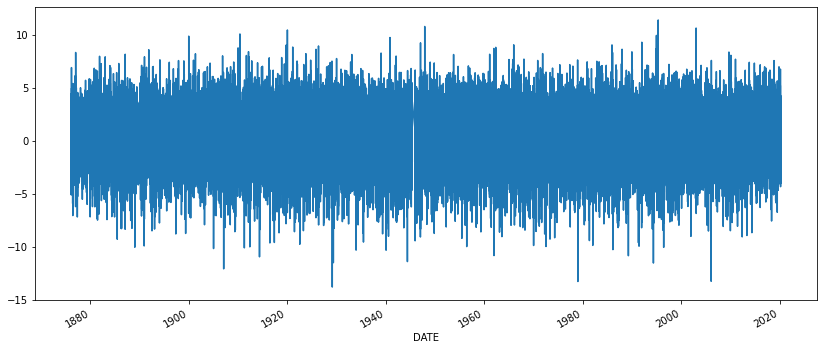

In [556]:
df_train_fe.remainder.plot()

## 8) Test

In [401]:
df_test_fe = feature_engineer(df_test)

df.tail() = df_test_fe.copy().iloc[:,0]
X_test = df_test_fe.copy().iloc[:,1:]

SyntaxError: cannot assign to function call (<ipython-input-401-f1ed17c975ad>, line 3)

In [402]:
r2 = round(m.score(X_test, y_test), 2)

NameError: name 'X_test' is not defined

In [403]:
print(f'The R-squared of our model is {r2}')

NameError: name 'r2' is not defined

In [404]:
# test 100 years later

In [557]:
# full m model
df['timestep'] = range(len(df))

from sklearn.linear_model import LinearRegression
baseline_model = LinearRegression()

df_past = feature_engineer(df)

In [558]:
df_past

,TG2,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-4.924877,1.175155,3.375188,3.075221
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-8.924910,-4.924877,1.175155,3.375188
1876-01-07,-6.6,6,0,0,0,0,0,0,0,0,0,0,0,-6.824943,-8.924910,-4.924877,1.175155
1876-01-08,-8.9,7,0,0,0,0,0,0,0,0,0,0,0,-5.724976,-6.824943,-8.924910,-4.924877
1876-01-09,-12.7,8,0,0,0,0,0,0,0,0,0,0,0,-8.025009,-5.724976,-6.824943,-8.924910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,6.9,52851,0,1,0,0,0,0,0,0,0,0,0,5.749478,4.249511,3.149544,0.949577
2021-03-28,7.7,52852,0,1,0,0,0,0,0,0,0,0,0,1.849445,5.749478,4.249511,3.149544
2021-03-29,14.4,52853,0,1,0,0,0,0,0,0,0,0,0,2.649412,1.849445,5.749478,4.249511


In [559]:
# define X, y
#X_past = df_past.drop(columns=['TG2'])
X_past = df_past.drop(columns=['TG2','lag1','lag2','lag3','lag4'])
# X_past = df_past.drop(columns=['TG2'])
y_past = df_past['TG2']

In [560]:
baseline_model.fit(X_past, y_past)

LinearRegression()

In [561]:
#df.tail()
X_past
# create predict future timeline table
# plot

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,52851,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,52852,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,52853,0,1,0,0,0,0,0,0,0,0,0


In [562]:
df_future = pd.DataFrame(index=pd.date_range(start='Apr 2021', end='Jan 2100', freq='D'))


In [563]:
last_timestep = max(df['timestep'])
last_timestep

52855

In [564]:
df_future['timestep'] = range(last_timestep + 1, last_timestep + 1 + len(df_future))

In [565]:
# get dummies
future_seasonal_dummies = pd.get_dummies(df_future.index.month, prefix='month',
                                  drop_first=True).set_index(df_future.index)
# merge table
df_future = pd.concat([df_future, future_seasonal_dummies], axis=1)
# 
df_future.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2021-04-01,52856,0,0,1,0,0,0,0,0,0,0,0
2021-04-02,52857,0,0,1,0,0,0,0,0,0,0,0
2021-04-03,52858,0,0,1,0,0,0,0,0,0,0,0
2021-04-04,52859,0,0,1,0,0,0,0,0,0,0,0
2021-04-05,52860,0,0,1,0,0,0,0,0,0,0,0


In [566]:
baseline_model.predict(df_future)

array([9.73799702, 9.73802996, 9.73806289, ..., 3.16953055, 3.16956349,
       1.81225419])

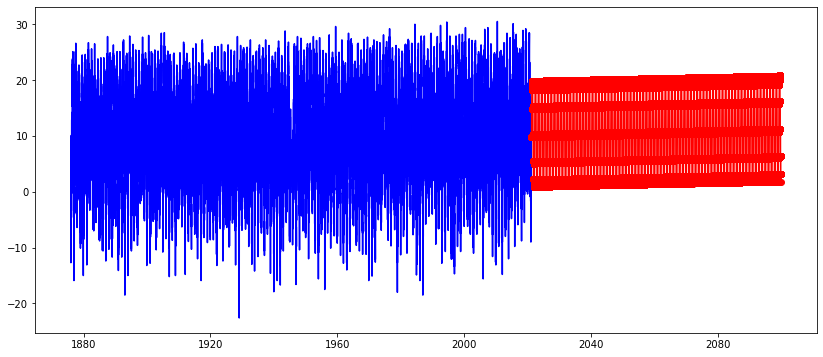

In [567]:
# no lag included
plt.plot(df['TG2'], 'b-')
plt.plot(df_future.index, baseline_model.predict(df_future), 'ro-')

In [497]:
# include lags
m_remainder = LinearRegression()

In [498]:
X_past

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,52851,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,52852,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,52853,0,1,0,0,0,0,0,0,0,0,0


In [499]:
df_past['TG2']

DATE
1876-01-05    -9.8
1876-01-06    -7.7
1876-01-07    -6.6
1876-01-08    -8.9
1876-01-09   -12.7
              ... 
2021-03-27     6.9
2021-03-28     7.7
2021-03-29    14.4
2021-03-30    14.9
2021-03-31    15.4
Name: TG2, Length: 52852, dtype: float64

In [500]:
X_past['pred_past'] = baseline_model.predict(X_past)

In [501]:
X_past['remainder'] = df_past['TG2'] - X_past['pred_past']

In [502]:
m_remainder.fit(X_past[['remainder']].shift(1)[1:], X_past['remainder'][1:])

LinearRegression()

In [503]:
X_past[['remainder']]

,remainder
DATE,
1876-01-05,-8.924160
1876-01-06,-6.824193
1876-01-07,-5.724226
1876-01-08,-8.024259
1876-01-09,-11.824292
...,...
2021-03-27,1.849292
2021-03-28,2.649259
2021-03-29,9.349226


In [569]:
X_past['pred_past'] = baseline_model.predict(X_past)

In [570]:
m_remainder.predict(X_past[['remainder']])

KeyError: "None of [Index(['remainder'], dtype='object')] are in the [columns]"

In [571]:
X_past

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,pred_past
DATE,,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-0.875840
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-0.875807
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0,-0.875774
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0,-0.875741
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0,-0.875708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,52851,0,1,0,0,0,0,0,0,0,0,0,5.050708
2021-03-28,52852,0,1,0,0,0,0,0,0,0,0,0,5.050741
2021-03-29,52853,0,1,0,0,0,0,0,0,0,0,0,5.050774


In [572]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(endog=X_past['remainder'], lags=3).fit()
ar_model.summary()

KeyError: 'remainder'

In [568]:
ar_model.predict(start='2020-03-31', end='2025-03-31')

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [573]:
predicted_remainder = np.zeros(len(df_future))
predicted_remainder[0] = m_remainder.predict(X_past[['remainder']][-1:])

KeyError: "None of [Index(['remainder'], dtype='object')] are in the [columns]"

In [574]:
predicted_remainder

array([0., 0., 0., ..., 0., 0., 0.])

In [575]:
df_future['pred_past_reminder'] = baseline_model.predict(df_future)

In [576]:
df_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,pred_past_reminder
2021-04-01,52856,0,0,1,0,0,0,0,0,0,0,0,9.737997
2021-04-02,52857,0,0,1,0,0,0,0,0,0,0,0,9.738030
2021-04-03,52858,0,0,1,0,0,0,0,0,0,0,0,9.738063
2021-04-04,52859,0,0,1,0,0,0,0,0,0,0,0,9.738096
2021-04-05,52860,0,0,1,0,0,0,0,0,0,0,0,9.738129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099-12-28,81616,0,0,0,0,0,0,0,0,0,0,1,3.169465
2099-12-29,81617,0,0,0,0,0,0,0,0,0,0,1,3.169498
2099-12-30,81618,0,0,0,0,0,0,0,0,0,0,1,3.169531
2099-12-31,81619,0,0,0,0,0,0,0,0,0,0,1,3.169563


In [577]:
predicted_remainder = df_future['pred_past_reminder'] 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 12 is different from 13)

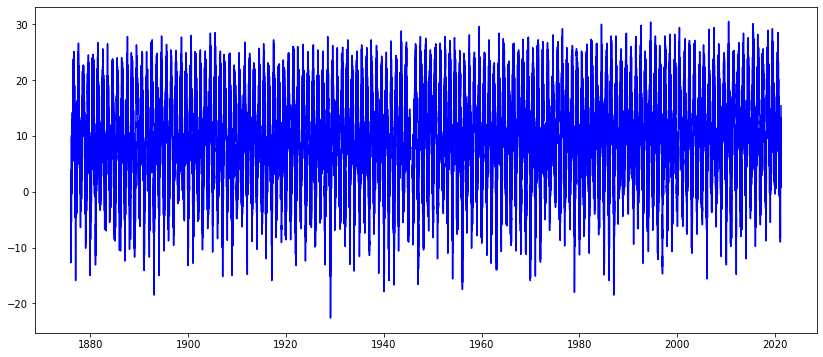

In [578]:
# lag included
plt.plot(df['TG2'], 'b-')
plt.plot(df_future.index, baseline_model.predict(df_future), 'ro-')
plt.plot(df_future.index, baseline_model.predict(df_future) + predicted_remainder, 'ro-')